# A tutorial on how to correct the hysteresis in a write path.

## NOTE: only works for x raster at the moment.

#### DO NOT CORRECT YOUR PATH IN HERE, KEEP THIS NOTEBOOK TIDY SO IT CAN BE UNDERSTOOD EASILY

#### The hysteresis here is modeled with a sin function. The paper with the technique to calculate the hysteresis for a set of images is https://pubs.aip.org/aip/rsi/article/90/2/023704/361826 (A method to correct hysteresis of scanning probe microscope images using sin method) .
#### I then calculate k (the amplitude of the sin function) for a range of different sized scans. We then plot the ks against the scan size and fit a parabola to this.
#### From the hysteresis analysis notebook, we worked out that the hysteresis constant k has the following equation:

### k(x) = 3.7e-06x^2 + 0.0087x

#### where x is the scan size

##### NOTE: I have copy and pasted the needed functions in here so you can easily read them if you want more details. However, they are also in NavigatingTheMatrix and can be imported from there and used from there when you make a new notebook/script. 
##### i.e. from NavigatingTheMatrix import quadratic_func, correct_path, plot_lithography_path

### Now we can use this to get the k value for any scan size.
### We can also use it to get the k value for any width of path i.e. even if the width of the path changes during the lithography, we can work out the appropriate k for each raster line.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# Define the quadratic function that passes through the origin
def quadratic_func(x):
    a = 3.7E-6
    b = 0.0087
    return a * x**2 + b * x 

# e.g.
print(f'The k value for a raster line of 4um is {quadratic_func(4000)}')
print(f'The k value for a raster line of 1um is {quadratic_func(1000)}')

Th k value for a raster line of 4um is 94.0
Th k value for a raster line of 1um is 12.399999999999999


##### Now we just use this k, and the sin model to correct the path.
##### Read the correct_path description for more details.

In [ ]:
def correct_path(path, write_field_size):
    '''
    Corrects the inaccuracies in path due to hysteresis
    args:
        path: path in the form we need for mate script
        write_field_size: the size of the write field in nm
    returns:
        new_path: the corrected path
        xs: x-values of the raster extremes on each raster line

    '''
    # steps:
    # 1. Find the width of each raster line. This will be used to calculate the k value for that line
    # 2. Find the number of points in each raster line. This will be used to know when we are at the end of a raster line
    # 3. Correct each point. Correction depends on whether we are in a fwd or bwd trace and raster width.

    # find the number of points in each raster and the k values

    num_points = [0] # number of points per raster, start with 0 
    raster = 0 #  raster we are currently on
    
    # the x values of the raster extremes (needed to calculate the k value of hysteresis)
    # these should come in pairs [start, end] so xs is list of lists
    xs = [[path[0][0][0]]] 
    old_point = path[0][0]
    for subpath in path:
        # subpath_array = np.array(subpath)
        # split the subpath depending on number of different y values
        for i, point in enumerate(subpath):
            dy =  point[1] - old_point[1]
            if np.allclose(point[1], old_point[1]): 
                # we are still in same raster
                num_points[raster] += 1
            else:
                # we are in a new raster
                num_points.append(1)
                raster += 1
                xs[-1].append(old_point[0])
                xs.append([point[0]])
            old_point  = 1*point
   
    # add the last x value
    xs[-1].append(path[-1][-1][0])
    # we have the extremes of the rasters, now we need to calculate the k values
    xs_array = np.array(xs)
    raster_lengths = np.abs(xs_array[:,1] - xs_array[:,0])*write_field_size
    
    k_values = [quadratic_func(raster_length)/write_field_size for raster_length in raster_lengths]
    # now we need to correct the path
    new_path = []
    raster = 0
    npoint = 0

   # points = [point for point in subpath for subpath in path] # list for all points (no sublists)
    for i, subpath in enumerate(path):
        # find whether we start with a fwd or bwd trace
        # and define the toggle
        if subpath[0][0] < subpath[1][0]:
            # we start with a fwd trace
            toggle = -1
        else:
            # we start with a bwd trace
            toggle = 1
        new_subpath = []
        for l, point in enumerate(subpath):
            sin_arg = write_field_size*point[0]*np.pi/raster_lengths[raster]
            correction = np.sum(k_values[raster]*np.sin(sin_arg))
            if raster_lengths[raster] == 0:
                print(f'Warning: raster length is 0 for raster {raster}, check your Matlab path for identical points!')
            new_subpath.append( [ point[0] + toggle*correction, point[1] ] )
            npoint += 1

            # check if we are at the end of a raster line
            #print(npoint, num_points[raster])
            if int(npoint) == int(num_points[raster]):
                raster += 1
                npoint = 0
                toggle = -1*toggle
            #print(toggle)


        new_path.append(new_subpath)

    return new_path, xs, raster
        

In [310]:
def plot_lithography_path(path, x_lim = None, y_lim = None):
    '''
    Plots a lithography path that is in the format needed for the MATE script 
    i.e. a list of lists. Each sublist contains a list of points. 
    In the plot, each sublist (subpath) is a different color (although matplotlib
    only has so many colours so it may repeat colours).  

    Args:
        path (list): A list of subpaths, where each subpath is a list of points.
        x_lim (tuple): Optional. The x-axis limits for the plot.
        y_lim (tuple): Optional. The y-axis limits for the plot.
    '''

    for subpath in path:
        # Convert the subpath to a numpy array
        subpath = np.array(subpath)
        
        # Plot the subpath
        plt.plot(subpath[:, 0], subpath[:, 1], linestyle='-')
        
    # Set the aspect ratio to be equal
    plt.gca().set_aspect('equal', adjustable='box')
    if x_lim is not None:
        plt.xlim(x_lim)
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Lithography Path')
    plt.show()


In [327]:
path = [[[0.5637500, 0.0012500],[0.4392500, 0.0012500],[0.4392500, 0.0027500],[0.5637500, 0.0027500],[0.5637500, 0.0042500],[0.4392500, 0.0042500],[0.4392500, 0.0057500],[0.5637500, 0.0057500],[0.5637500, 0.0072500],[0.4392500, 0.0072500],[0.4392500, 0.0087500],[0.5637500, 0.0087500],[0.5637500, 0.0102500],[0.4392500, 0.0102500],[0.4392500, 0.0117500],[0.5637500, 0.0117500],[0.5637500, 0.0132500],[0.4392500, 0.0132500],[0.4392500, 0.0147500],[0.5637500, 0.0147500],[0.5637500, 0.0162500],[0.4392500, 0.0162500],[0.4392500, 0.0177500],[0.5637500, 0.0177500],[0.5637500, 0.0192500],[0.4392500, 0.0192500],[0.4392500, 0.0207500],[0.5637500, 0.0207500],[0.5637500, 0.0222500],[0.4392500, 0.0222500],[0.4392500, 0.0237500],[0.5637500, 0.0237500],[0.5637500, 0.0252500],[0.4392500, 0.0252500],[0.4392500, 0.0267500],[0.5637500, 0.0267500],[0.5637500, 0.0282500],[0.4392500, 0.0282500],[0.4392500, 0.0297500],[0.5637500, 0.0297500],[0.5637500, 0.0312500],[0.4392500, 0.0312500],[0.4392500, 0.0327500],[0.5637500, 0.0327500],[0.5637500, 0.0342500],[0.4392500, 0.0342500],[0.4392500, 0.0357500],[0.5637500, 0.0357500],[0.5637500, 0.0372500],[0.4392500, 0.0372500],[0.4392500, 0.0387500],[0.5637500, 0.0387500],[0.5637500, 0.0402500],[0.4392500, 0.0402500],[0.4392500, 0.0417500],[0.5637500, 0.0417500],[0.5637500, 0.0432500],[0.4392500, 0.0432500],[0.4392500, 0.0447500],[0.5637500, 0.0447500],[0.5637500, 0.0462500],[0.4392500, 0.0462500],[0.4392500, 0.0477500],[0.5637500, 0.0477500],[0.5637500, 0.0492500],[0.4392500, 0.0492500],[0.4392500, 0.0507500],[0.5637500, 0.0507500],[0.5637500, 0.0522500],[0.4392500, 0.0522500],[0.4392500, 0.0537500],[0.5637500, 0.0537500],[0.5637500, 0.0552500],[0.4392500, 0.0552500],[0.4392500, 0.0567500],[0.5637500, 0.0567500],[0.5637500, 0.0582500],[0.4392500, 0.0582500],[0.4392500, 0.0597500],[0.5637500, 0.0597500],[0.5637500, 0.0612500],[0.4392500, 0.0612500],[0.4392500, 0.0627500],[0.5637500, 0.0627500],[0.5637500, 0.0642500],[0.4392500, 0.0642500],[0.4392500, 0.0657500],[0.5637500, 0.0657500],[0.5637500, 0.0672500],[0.4392500, 0.0672500],[0.4392500, 0.0687500],[0.5637500, 0.0687500],[0.5637500, 0.0702500],[0.4392500, 0.0702500],[0.4392500, 0.0717500],[0.5637500, 0.0717500],[0.5637500, 0.0732500],[0.4392500, 0.0732500],[0.4392500, 0.0747500],[0.5637500, 0.0747500],[0.5637500, 0.0762500],[0.4392500, 0.0762500],[0.4392500, 0.0777500],[0.5637500, 0.0777500],[0.5637500, 0.0792500],[0.4392500, 0.0792500],[0.4392500, 0.0807500],[0.5637500, 0.0807500],[0.5637500, 0.0822500],[0.4392500, 0.0822500],[0.4392500, 0.0837500],[0.5637500, 0.0837500],[0.5637500, 0.0852500],[0.4392500, 0.0852500],[0.4392500, 0.0867500],[0.5637500, 0.0867500],[0.5637500, 0.0882500],[0.4392500, 0.0882500],[0.4392500, 0.0897500],[0.5637500, 0.0897500],[0.5637500, 0.0912500],[0.4392500, 0.0912500],[0.4392500, 0.0927500],[0.5637500, 0.0927500],[0.5637500, 0.0942500],[0.4392500, 0.0942500],[0.4392500, 0.0957500],[0.5637500, 0.0957500],[0.5637500, 0.0972500],[0.4392500, 0.0972500],[0.4392500, 0.0987500],[0.5637500, 0.0987500],[0.5637500, 0.1002500],[0.4392500, 0.1002500],[0.4392500, 0.1017500],[0.5637500, 0.1017500],[0.5637500, 0.1032500],[0.4392500, 0.1032500],[0.4392500, 0.1047500],[0.5637500, 0.1047500],[0.5637500, 0.1062500],[0.4392500, 0.1062500],[0.4392500, 0.1077500],[0.5637500, 0.1077500],[0.5637500, 0.1092500],[0.4392500, 0.1092500],[0.4392500, 0.1107500],[0.5637500, 0.1107500],[0.5637500, 0.1122500],[0.4392500, 0.1122500],[0.4392500, 0.1137500],[0.5637500, 0.1137500],[0.5637500, 0.1152500],[0.4392500, 0.1152500],[0.4392500, 0.1167500],[0.5637500, 0.1167500],[0.5637500, 0.1182500],[0.4392500, 0.1182500],[0.4392500, 0.1197500],[0.5637500, 0.1197500],[0.5637500, 0.1212500],[0.4392500, 0.1212500],[0.4392500, 0.1227500],[0.5637500, 0.1227500],[0.5637500, 0.1242500],[0.4392500, 0.1242500],[0.4392500, 0.1257500],[0.5637500, 0.1257500],[0.5637500, 0.1272500],[0.4392500, 0.1272500],[0.4392500, 0.1287500],[0.5637500, 0.1287500],[0.5637500, 0.1302500],[0.4392500, 0.1302500],[0.4392500, 0.1317500],[0.5637500, 0.1317500],[0.5637500, 0.1332500],[0.4392500, 0.1332500],[0.4392500, 0.1347500],[0.5637500, 0.1347500],[0.5637500, 0.1362500],[0.4392500, 0.1362500],[0.4392500, 0.1377500],[0.5637500, 0.1377500],[0.5637500, 0.1392500],[0.4392500, 0.1392500],[0.4392500, 0.1407500],[0.5637500, 0.1407500],[0.5637500, 0.1422500],[0.4392500, 0.1422500],[0.4392500, 0.1437500],[0.5637500, 0.1437500],[0.5637500, 0.1452500],[0.4392500, 0.1452500],[0.4392500, 0.1467500],[0.5637500, 0.1467500],[0.5637500, 0.1482500],[0.4392500, 0.1482500],[0.4392500, 0.1497500],[0.5637500, 0.1497500],[0.5637500, 0.1512500],[0.4392500, 0.1512500],[0.4392500, 0.1527500],[0.5637500, 0.1527500],[0.5637500, 0.1542500],[0.4392500, 0.1542500],[0.4392500, 0.1557500],[0.5637500, 0.1557500],[0.5637500, 0.1572500],[0.4392500, 0.1572500],[0.4392500, 0.1587500],[0.5637500, 0.1587500],[0.5637500, 0.1602500],[0.4392500, 0.1602500],[0.4392500, 0.1617500],[0.5637500, 0.1617500],[0.5637500, 0.1632500],[0.4392500, 0.1632500],[0.4392500, 0.1647500],[0.5637500, 0.1647500],[0.5637500, 0.1662500],[0.4392500, 0.1662500],[0.4392500, 0.1677500],[0.5637500, 0.1677500],[0.5637500, 0.1692500],[0.4392500, 0.1692500],[0.4392500, 0.1707500],[0.5637500, 0.1707500],[0.5637500, 0.1722500],[0.4392500, 0.1722500],[0.4392500, 0.1737500],[0.5637500, 0.1737500],[0.5637500, 0.1752500],[0.4392500, 0.1752500],[0.4392500, 0.1767500],[0.5637500, 0.1767500],[0.5637500, 0.1782500],[0.4392500, 0.1782500],[0.4392500, 0.1797500],[0.5637500, 0.1797500],[0.5637500, 0.1812500],[0.4392500, 0.1812500],[0.4392500, 0.1827500],[0.5637500, 0.1827500],[0.5637500, 0.1842500],[0.4392500, 0.1842500],[0.4392500, 0.1857500],[0.5637500, 0.1857500],[0.5637500, 0.1872500],[0.4392500, 0.1872500],[0.4392500, 0.1887500],[0.5637500, 0.1887500],[0.5637500, 0.1902500],[0.4392500, 0.1902500],[0.4392500, 0.1917500],[0.5637500, 0.1917500],[0.5637500, 0.1932500],[0.4392500, 0.1932500],[0.4392500, 0.1947500],[0.5637500, 0.1947500],[0.5637500, 0.1962500],[0.4392500, 0.1962500],[0.4392500, 0.1977500],[0.5637500, 0.1977500],[0.5637500, 0.1992500],[0.4392500, 0.1992500],[0.4392500, 0.2007500],[0.5637500, 0.2007500],[0.5637500, 0.2022500],[0.4392500, 0.2022500],[0.4392500, 0.2037500],[0.5637500, 0.2037500],[0.5637500, 0.2052500],[0.4392500, 0.2052500],[0.4392500, 0.2067500],[0.5637500, 0.2067500],[0.5637500, 0.2082500],[0.4392500, 0.2082500],[0.4392500, 0.2097500],[0.5637500, 0.2097500],[0.5637500, 0.2112500],[0.4392500, 0.2112500],[0.4392500, 0.2127500],[0.5637500, 0.2127500],[0.5637500, 0.2142500],[0.4392500, 0.2142500],[0.4392500, 0.2157500],[0.5637500, 0.2157500],[0.5637500, 0.2172500],[0.4392500, 0.2172500],[0.4392500, 0.2187500],[0.5637500, 0.2187500],[0.5637500, 0.2202500],[0.4392500, 0.2202500],[0.4392500, 0.2217500],[0.5637500, 0.2217500],[0.5637500, 0.2232500],[0.4392500, 0.2232500],[0.4392500, 0.2247500],[0.5637500, 0.2247500],[0.5637500, 0.2262500],[0.4392500, 0.2262500],[0.4392500, 0.2277500],[0.5637500, 0.2277500],[0.5637500, 0.2292500],[0.4392500, 0.2292500],[0.4392500, 0.2307500],[0.5637500, 0.2307500],[0.5637500, 0.2322500],[0.4392500, 0.2322500],[0.4392500, 0.2337500],[0.5637500, 0.2337500],[0.5637500, 0.2352500],[0.4392500, 0.2352500],[0.4392500, 0.2367500],[0.5637500, 0.2367500],[0.5637500, 0.2382500],[0.4392500, 0.2382500],[0.4392500, 0.2397500],[0.5637500, 0.2397500],[0.5637500, 0.2412500],[0.4392500, 0.2412500],[0.4392500, 0.2427500],[0.5637500, 0.2427500],[0.5637500, 0.2442500],[0.4392500, 0.2442500],[0.4392500, 0.2457500],[0.5637500, 0.2457500],[0.5637500, 0.2472500],[0.4392500, 0.2472500],[0.4392500, 0.2487500],[0.5637500, 0.2487500],[0.5637500, 0.2502500],[0.4392500, 0.2502500],[0.4392500, 0.2517500],[0.5637500, 0.2517500],[0.5637500, 0.2532500],[0.4392500, 0.2532500],[0.4392500, 0.2547500],[0.5637500, 0.2547500],[0.5637500, 0.2562500],[0.4392500, 0.2562500],[0.4392500, 0.2577500],[0.5637500, 0.2577500],[0.5637500, 0.2592500],[0.4392500, 0.2592500],[0.4392500, 0.2607500],[0.5637500, 0.2607500],[0.5637500, 0.2622500],[0.4392500, 0.2622500],[0.4392500, 0.2637500],[0.5637500, 0.2637500],[0.5637500, 0.2652500],[0.4392500, 0.2652500],[0.4392500, 0.2667500],[0.5637500, 0.2667500],[0.5637500, 0.2682500],[0.4392500, 0.2682500],[0.4392500, 0.2697500],[0.5637500, 0.2697500],[0.5637500, 0.2712500],[0.4392500, 0.2712500],[0.4392500, 0.2727500],[0.5637500, 0.2727500],[0.5637500, 0.2742500],[0.4392500, 0.2742500],[0.4392500, 0.2757500],[0.5637500, 0.2757500],[0.5637500, 0.2772500],[0.4392500, 0.2772500],[0.4392500, 0.2787500],[0.5637500, 0.2787500],[0.5637500, 0.2802500],[0.4392500, 0.2802500],[0.4392500, 0.2817500],[0.5637500, 0.2817500],[0.5637500, 0.2832500],[0.4392500, 0.2832500],[0.4392500, 0.2847500],[0.5637500, 0.2847500],[0.5637500, 0.2862500],[0.4392500, 0.2862500],[0.4392500, 0.2877500],[0.5637500, 0.2877500],[0.5637500, 0.2892500],[0.4392500, 0.2892500],[0.4392500, 0.2907500],[0.5637500, 0.2907500],[0.5637500, 0.2922500],[0.4392500, 0.2922500],[0.4392500, 0.2937500],[0.5637500, 0.2937500],[0.5637500, 0.2952500],[0.4392500, 0.2952500],[0.4392500, 0.2967500],[0.5637500, 0.2967500],[0.5637500, 0.2982500],[0.4392500, 0.2982500],[0.4392500, 0.2997500],[0.5637500, 0.2997500],[0.5637500, 0.3012500],[0.4392500, 0.3012500],[0.4392500, 0.3027500],[0.5637500, 0.3027500],[0.5637500, 0.3042500],[0.4392500, 0.3042500],[0.4392500, 0.3057500],[0.5637500, 0.3057500],[0.5637500, 0.3072500],[0.4392500, 0.3072500],[0.4392500, 0.3087500],[0.5637500, 0.3087500],[0.5637500, 0.3102500],[0.4392500, 0.3102500],[0.4392500, 0.3117500],[0.5637500, 0.3117500],[0.5637500, 0.3132500],[0.4392500, 0.3132500],[0.4392500, 0.3147500],[0.5637500, 0.3147500],[0.5637500, 0.3162500],[0.4392500, 0.3162500],[0.4392500, 0.3177500],[0.5637500, 0.3177500],[0.5637500, 0.3192500],[0.4392500, 0.3192500],[0.4407500, 0.3207500],[0.5622500, 0.3207500],[0.5607500, 0.3222500],[0.4422500, 0.3222500],[0.4422500, 0.3237500],[0.5592500, 0.3237500],[0.5592500, 0.3252500],[0.4437500, 0.3252500],[0.4452500, 0.3267500],[0.5577500, 0.3267500],[0.5562500, 0.3282500],[0.4467500, 0.3282500],[0.4482500, 0.3297500],[0.5547500, 0.3297500],[0.5532500, 0.3312500],[0.4482500, 0.3312500],[0.4497500, 0.3327500],[0.5532500, 0.3327500],[0.5517500, 0.3342500],[0.4512500, 0.3342500],[0.4527500, 0.3357500],[0.5502500, 0.3357500],[0.5487500, 0.3372500],[0.4542500, 0.3372500],[0.4542500, 0.3387500],[0.5472500, 0.3387500],[0.5472500, 0.3402500],[0.4557500, 0.3402500],[0.4572500, 0.3417500],[0.5457500, 0.3417500],[0.5442500, 0.3432500],[0.4587500, 0.3432500],[0.4602500, 0.3447500],[0.5427500, 0.3447500],[0.5412500, 0.3462500],[0.4602500, 0.3462500],[0.4617500, 0.3477500],[0.5412500, 0.3477500],[0.5397500, 0.3492500],[0.4632500, 0.3492500],[0.4647500, 0.3507500],[0.5382500, 0.3507500],[0.5367500, 0.3522500],[0.4662500, 0.3522500],[0.4662500, 0.3537500],[0.5352500, 0.3537500],[0.5352500, 0.3552500],[0.4677500, 0.3552500],[0.4692500, 0.3567500],[0.5337500, 0.3567500],[0.5322500, 0.3582500],[0.4707500, 0.3582500],[0.4722500, 0.3597500],[0.5307500, 0.3597500],[0.5292500, 0.3612500],[0.4722500, 0.3612500],[0.4737500, 0.3627500],[0.5292500, 0.3627500],[0.5277500, 0.3642500],[0.4752500, 0.3642500],[0.4767500, 0.3657500],[0.5262500, 0.3657500],[0.5247500, 0.3672500],[0.4767500, 0.3672500],[0.4767500, 0.3687500],[0.5247500, 0.3687500],[0.5247500, 0.3702500],[0.4767500, 0.3702500],[0.4767500, 0.3717500],[0.5247500, 0.3717500],[0.5247500, 0.3732500],[0.4767500, 0.3732500],[0.4767500, 0.3747500],[0.5247500, 0.3747500],[0.5247500, 0.3762500],[0.4767500, 0.3762500],[0.4767500, 0.3777500],[0.5247500, 0.3777500],[0.5247500, 0.3792500],[0.4767500, 0.3792500],[0.4767500, 0.3807500],[0.5247500, 0.3807500],[0.5247500, 0.3822500],[0.4767500, 0.3822500],[0.4767500, 0.3837500],[0.5247500, 0.3837500],[0.5247500, 0.3852500],[0.4767500, 0.3852500],[0.4767500, 0.3867500],[0.5247500, 0.3867500],[0.5247500, 0.3882500],[0.4767500, 0.3882500],[0.4767500, 0.3897500],[0.5247500, 0.3897500],[0.5247500, 0.3912500],[0.4767500, 0.3912500],[0.4767500, 0.3927500],[0.5247500, 0.3927500],[0.5247500, 0.3942500],[0.4767500, 0.3942500],[0.4767500, 0.3957500],[0.5247500, 0.3957500],[0.5247500, 0.3972500],[0.4767500, 0.3972500],[0.4767500, 0.3987500],[0.5247500, 0.3987500],[0.5247500, 0.4002500],[0.4767500, 0.4002500],[0.4767500, 0.4017500],[0.5247500, 0.4017500],[0.5247500, 0.4032500],[0.4767500, 0.4032500],[0.4767500, 0.4047500],[0.5247500, 0.4047500],[0.5247500, 0.4062500],[0.4767500, 0.4062500],[0.4767500, 0.4077500],[0.5247500, 0.4077500],[0.5247500, 0.4092500],[0.4767500, 0.4092500],[0.4767500, 0.4107500],[0.5247500, 0.4107500],[0.5247500, 0.4122500],[0.4767500, 0.4122500],[0.4767500, 0.4137500],[0.5247500, 0.4137500],[0.5247500, 0.4152500],[0.4767500, 0.4152500],[0.4767500, 0.4167500],[0.5247500, 0.4167500],[0.5247500, 0.4182500],[0.4767500, 0.4182500],[0.4767500, 0.4197500],[0.5247500, 0.4197500],[0.5247500, 0.4212500],[0.4767500, 0.4212500],[0.4767500, 0.4227500],[0.5247500, 0.4227500],[0.5247500, 0.4242500],[0.4767500, 0.4242500],[0.4767500, 0.4257500],[0.5247500, 0.4257500]],[[0.9987500, 0.4527500],[0.6357500, 0.4527500]],[[0.3657500, 0.4527500],[0.0012500, 0.4527500],[0.0012500, 0.4542500],[0.3672500, 0.4542500]],[[0.6342500, 0.4542500],[0.9987500, 0.4542500],[0.9987500, 0.4557500],[0.6312500, 0.4557500]],[[0.3687500, 0.4557500],[0.0012500, 0.4557500],[0.0012500, 0.4572500],[0.3717500, 0.4572500]],[[0.6297500, 0.4572500],[0.9987500, 0.4572500],[0.9987500, 0.4587500],[0.6282500, 0.4587500]],[[0.3732500, 0.4587500],[0.0012500, 0.4587500],[0.0012500, 0.4602500],[0.3747500, 0.4602500]],[[0.6267500, 0.4602500],[0.9987500, 0.4602500],[0.9987500, 0.4617500],[0.6237500, 0.4617500]],[[0.3762500, 0.4617500],[0.0012500, 0.4617500],[0.0012500, 0.4632500],[0.3792500, 0.4632500]],[[0.6222500, 0.4632500],[0.9987500, 0.4632500],[0.9987500, 0.4647500],[0.6207500, 0.4647500]],[[0.3807500, 0.4647500],[0.0012500, 0.4647500],[0.0012500, 0.4662500],[0.3822500, 0.4662500]],[[0.6192500, 0.4662500],[0.9987500, 0.4662500],[0.9987500, 0.4677500],[0.6162500, 0.4677500]],[[0.3837500, 0.4677500],[0.0012500, 0.4677500],[0.0012500, 0.4692500],[0.3867500, 0.4692500]],[[0.6147500, 0.4692500],[0.9987500, 0.4692500],[0.9987500, 0.4707500],[0.6132500, 0.4707500]],[[0.3882500, 0.4707500],[0.0012500, 0.4707500],[0.0012500, 0.4722500],[0.3897500, 0.4722500]],[[0.6117500, 0.4722500],[0.9987500, 0.4722500],[0.9987500, 0.4737500],[0.6087500, 0.4737500]],[[0.3912500, 0.4737500],[0.0012500, 0.4737500],[0.0012500, 0.4752500],[0.3942500, 0.4752500]],[[0.6072500, 0.4752500],[0.9987500, 0.4752500],[0.9987500, 0.4767500],[0.6057500, 0.4767500]],[[0.3957500, 0.4767500],[0.0012500, 0.4767500],[0.0012500, 0.4782500],[0.3972500, 0.4782500]],[[0.6042500, 0.4782500],[0.9987500, 0.4782500],[0.9987500, 0.4797500],[0.6012500, 0.4797500]],[[0.3987500, 0.4797500],[0.0012500, 0.4797500],[0.0012500, 0.4812500],[0.4017500, 0.4812500]],[[0.5997500, 0.4812500],[0.9987500, 0.4812500],[0.9987500, 0.4827500],[0.5982500, 0.4827500]],[[0.4032500, 0.4827500],[0.0012500, 0.4827500],[0.0012500, 0.4842500],[0.4047500, 0.4842500]],[[0.5967500, 0.4842500],[0.9987500, 0.4842500],[0.9987500, 0.4857500],[0.5937500, 0.4857500]],[[0.4062500, 0.4857500],[0.0012500, 0.4857500],[0.0012500, 0.4872500],[0.4092500, 0.4872500]],[[0.5922500, 0.4872500],[0.9987500, 0.4872500],[0.9987500, 0.4887500],[0.5907500, 0.4887500]],[[0.4107500, 0.4887500],[0.0012500, 0.4887500],[0.0012500, 0.4902500],[0.4122500, 0.4902500]],[[0.5892500, 0.4902500],[0.9987500, 0.4902500],[0.9987500, 0.4917500],[0.5862500, 0.4917500]],[[0.4137500, 0.4917500],[0.0012500, 0.4917500],[0.0012500, 0.4932500],[0.4152500, 0.4932500]],[[0.5847500, 0.4932500],[0.9987500, 0.4932500],[0.9987500, 0.4947500],[0.5847500, 0.4947500]],[[0.4152500, 0.4947500],[0.0012500, 0.4947500],[0.0012500, 0.4962500],[0.4152500, 0.4962500]],[[0.5847500, 0.4962500],[0.9987500, 0.4962500],[0.9987500, 0.4977500],[0.5847500, 0.4977500]],[[0.4152500, 0.4977500],[0.0012500, 0.4977500],[0.0012500, 0.4992500],[0.4152500, 0.4992500]],[[0.5847500, 0.4992500],[0.9987500, 0.4992500],[0.9987500, 0.5007500],[0.5847500, 0.5007500]],[[0.4152500, 0.5007500],[0.0012500, 0.5007500],[0.0012500, 0.5022500],[0.4152500, 0.5022500]],[[0.5847500, 0.5022500],[0.9987500, 0.5022500],[0.9987500, 0.5037500],[0.5847500, 0.5037500]],[[0.4152500, 0.5037500],[0.0012500, 0.5037500],[0.0012500, 0.5052500],[0.4152500, 0.5052500]],[[0.5847500, 0.5052500],[0.9987500, 0.5052500],[0.9987500, 0.5067500],[0.5847500, 0.5067500]],[[0.4152500, 0.5067500],[0.0012500, 0.5067500],[0.0012500, 0.5082500],[0.4152500, 0.5082500]],[[0.5847500, 0.5082500],[0.9987500, 0.5082500],[0.9987500, 0.5097500],[0.5847500, 0.5097500]],[[0.4152500, 0.5097500],[0.0012500, 0.5097500],[0.0012500, 0.5112500],[0.4152500, 0.5112500]],[[0.5847500, 0.5112500],[0.9987500, 0.5112500],[0.9987500, 0.5127500],[0.5847500, 0.5127500]],[[0.4152500, 0.5127500],[0.0012500, 0.5127500],[0.0012500, 0.5142500],[0.4152500, 0.5142500]],[[0.5847500, 0.5142500],[0.9987500, 0.5142500],[0.9987500, 0.5157500],[0.5847500, 0.5157500]],[[0.4152500, 0.5157500],[0.0012500, 0.5157500],[0.0012500, 0.5172500],[0.4152500, 0.5172500]],[[0.5847500, 0.5172500],[0.9987500, 0.5172500],[0.9987500, 0.5187500],[0.5847500, 0.5187500]],[[0.4152500, 0.5187500],[0.0012500, 0.5187500],[0.0012500, 0.5202500],[0.4152500, 0.5202500]],[[0.5847500, 0.5202500],[0.9987500, 0.5202500],[0.9987500, 0.5217500],[0.5847500, 0.5217500]],[[0.4152500, 0.5217500],[0.0012500, 0.5217500],[0.0012500, 0.5232500],[0.4152500, 0.5232500]],[[0.5847500, 0.5232500],[0.9987500, 0.5232500],[0.9987500, 0.5247500],[0.5847500, 0.5247500]],[[0.4152500, 0.5247500],[0.0012500, 0.5247500],[0.0012500, 0.5262500],[0.4152500, 0.5262500]],[[0.5847500, 0.5262500],[0.9987500, 0.5262500],[0.9987500, 0.5277500],[0.5847500, 0.5277500]],[[0.4152500, 0.5277500],[0.0012500, 0.5277500],[0.0012500, 0.5292500],[0.4152500, 0.5292500]],[[0.5847500, 0.5292500],[0.9987500, 0.5292500],[0.9987500, 0.5307500],[0.5847500, 0.5307500]],[[0.4152500, 0.5307500],[0.0012500, 0.5307500],[0.0012500, 0.5322500],[0.4152500, 0.5322500]],[[0.5847500, 0.5322500],[0.9987500, 0.5322500],[0.9987500, 0.5337500],[0.5847500, 0.5337500]],[[0.4152500, 0.5337500],[0.0012500, 0.5337500],[0.0012500, 0.5352500],[0.4152500, 0.5352500]],[[0.5847500, 0.5352500],[0.9987500, 0.5352500],[0.9987500, 0.5367500],[0.5847500, 0.5367500]],[[0.4152500, 0.5367500],[0.0012500, 0.5367500],[0.0012500, 0.5382500],[0.4137500, 0.5382500]],[[0.5862500, 0.5382500],[0.9987500, 0.5382500],[0.9987500, 0.5397500],[0.5877500, 0.5397500]],[[0.4122500, 0.5397500],[0.0012500, 0.5397500],[0.0012500, 0.5412500],[0.4092500, 0.5412500]],[[0.5892500, 0.5412500],[0.9987500, 0.5412500],[0.9987500, 0.5427500],[0.5922500, 0.5427500]],[[0.4077500, 0.5427500],[0.0012500, 0.5427500],[0.0012500, 0.5442500],[0.4062500, 0.5442500]],[[0.5937500, 0.5442500],[0.9987500, 0.5442500],[0.9987500, 0.5457500],[0.5952500, 0.5457500]],[[0.4047500, 0.5457500],[0.0012500, 0.5457500],[0.0012500, 0.5472500],[0.4017500, 0.5472500]],[[0.5967500, 0.5472500],[0.9987500, 0.5472500],[0.9987500, 0.5487500],[0.5997500, 0.5487500]],[[0.4002500, 0.5487500],[0.0012500, 0.5487500],[0.0012500, 0.5502500],[0.3987500, 0.5502500]],[[0.6012500, 0.5502500],[0.9987500, 0.5502500],[0.9987500, 0.5517500],[0.6027500, 0.5517500]],[[0.3972500, 0.5517500],[0.0012500, 0.5517500],[0.0012500, 0.5532500],[0.3942500, 0.5532500]],[[0.6042500, 0.5532500],[0.9987500, 0.5532500],[0.9987500, 0.5547500],[0.6072500, 0.5547500]],[[0.3927500, 0.5547500],[0.0012500, 0.5547500],[0.0012500, 0.5562500],[0.3912500, 0.5562500]],[[0.6087500, 0.5562500],[0.9987500, 0.5562500],[0.9987500, 0.5577500],[0.6102500, 0.5577500]],[[0.3897500, 0.5577500],[0.0012500, 0.5577500],[0.0012500, 0.5592500],[0.3867500, 0.5592500]],[[0.6117500, 0.5592500],[0.9987500, 0.5592500],[0.9987500, 0.5607500],[0.6147500, 0.5607500]],[[0.3852500, 0.5607500],[0.0012500, 0.5607500],[0.0012500, 0.5622500],[0.3837500, 0.5622500]],[[0.6162500, 0.5622500],[0.9987500, 0.5622500],[0.9987500, 0.5637500],[0.6177500, 0.5637500]],[[0.3822500, 0.5637500],[0.0012500, 0.5637500],[0.0012500, 0.5652500],[0.3792500, 0.5652500]],[[0.6192500, 0.5652500],[0.9987500, 0.5652500],[0.9987500, 0.5667500],[0.6222500, 0.5667500]],[[0.3777500, 0.5667500],[0.0012500, 0.5667500],[0.0012500, 0.5682500],[0.3762500, 0.5682500]],[[0.6237500, 0.5682500],[0.9987500, 0.5682500],[0.9987500, 0.5697500],[0.6252500, 0.5697500]],[[0.3747500, 0.5697500],[0.0012500, 0.5697500],[0.0012500, 0.5712500],[0.3717500, 0.5712500]],[[0.6267500, 0.5712500],[0.9987500, 0.5712500],[0.9987500, 0.5727500],[0.6297500, 0.5727500]],[[0.3702500, 0.5727500],[0.0012500, 0.5727500],[0.0012500, 0.5742500],[0.3687500, 0.5742500]],[[0.6312500, 0.5742500],[0.9987500, 0.5742500],[0.9987500, 0.5757500],[0.6327500, 0.5757500]],[[0.3672500, 0.5757500],[0.0012500, 0.5757500],[0.0012500, 0.5772500],[0.3657500, 0.5772500]],[[0.6342500, 0.5772500],[0.9987500, 0.5772500]],[[0.5247500, 0.6012500],[0.4767500, 0.6012500],[0.4767500, 0.6027500],[0.5247500, 0.6027500],[0.5247500, 0.6042500],[0.4767500, 0.6042500],[0.4767500, 0.6057500],[0.5247500, 0.6057500],[0.5247500, 0.6072500],[0.4767500, 0.6072500],[0.4767500, 0.6087500],[0.5247500, 0.6087500],[0.5247500, 0.6102500],[0.4767500, 0.6102500],[0.4767500, 0.6117500],[0.5247500, 0.6117500],[0.5247500, 0.6132500],[0.4767500, 0.6132500],[0.4767500, 0.6147500],[0.5247500, 0.6147500],[0.5247500, 0.6162500],[0.4767500, 0.6162500],[0.4767500, 0.6177500],[0.5247500, 0.6177500],[0.5247500, 0.6192500],[0.4767500, 0.6192500],[0.4767500, 0.6207500],[0.5247500, 0.6207500],[0.5247500, 0.6222500],[0.4767500, 0.6222500],[0.4767500, 0.6237500],[0.5247500, 0.6237500],[0.5247500, 0.6252500],[0.4767500, 0.6252500],[0.4767500, 0.6267500],[0.5247500, 0.6267500],[0.5247500, 0.6282500],[0.4767500, 0.6282500],[0.4767500, 0.6297500],[0.5247500, 0.6297500],[0.5247500, 0.6312500],[0.4767500, 0.6312500],[0.4767500, 0.6327500],[0.5247500, 0.6327500],[0.5247500, 0.6342500],[0.4767500, 0.6342500],[0.4767500, 0.6357500],[0.5247500, 0.6357500],[0.5247500, 0.6372500],[0.4767500, 0.6372500],[0.4767500, 0.6387500],[0.5247500, 0.6387500],[0.5247500, 0.6402500],[0.4767500, 0.6402500],[0.4767500, 0.6417500],[0.5247500, 0.6417500],[0.5247500, 0.6432500],[0.4767500, 0.6432500],[0.4767500, 0.6447500],[0.5247500, 0.6447500],[0.5247500, 0.6462500],[0.4767500, 0.6462500],[0.4767500, 0.6477500],[0.5247500, 0.6477500],[0.5247500, 0.6492500],[0.4767500, 0.6492500],[0.4767500, 0.6507500],[0.5247500, 0.6507500],[0.5247500, 0.6522500],[0.4767500, 0.6522500],[0.4767500, 0.6537500],[0.5247500, 0.6537500],[0.5262500, 0.6552500],[0.4767500, 0.6552500],[0.4752500, 0.6567500],[0.5277500, 0.6567500],[0.5277500, 0.6582500],[0.4737500, 0.6582500],[0.4722500, 0.6597500],[0.5292500, 0.6597500],[0.5307500, 0.6612500],[0.4707500, 0.6612500],[0.4707500, 0.6627500],[0.5322500, 0.6627500],[0.5337500, 0.6642500],[0.4692500, 0.6642500],[0.4677500, 0.6657500],[0.5337500, 0.6657500],[0.5352500, 0.6672500],[0.4662500, 0.6672500],[0.4647500, 0.6687500],[0.5367500, 0.6687500],[0.5382500, 0.6702500],[0.4647500, 0.6702500],[0.4632500, 0.6717500],[0.5397500, 0.6717500],[0.5397500, 0.6732500],[0.4617500, 0.6732500],[0.4602500, 0.6747500],[0.5412500, 0.6747500],[0.5427500, 0.6762500],[0.4587500, 0.6762500],[0.4587500, 0.6777500],[0.5442500, 0.6777500],[0.5457500, 0.6792500],[0.4572500, 0.6792500],[0.4557500, 0.6807500],[0.5457500, 0.6807500],[0.5472500, 0.6822500],[0.4542500, 0.6822500],[0.4527500, 0.6837500],[0.5487500, 0.6837500],[0.5502500, 0.6852500],[0.4527500, 0.6852500],[0.4512500, 0.6867500],[0.5517500, 0.6867500],[0.5517500, 0.6882500],[0.4497500, 0.6882500],[0.4482500, 0.6897500],[0.5532500, 0.6897500],[0.5547500, 0.6912500],[0.4467500, 0.6912500],[0.4467500, 0.6927500],[0.5562500, 0.6927500],[0.5577500, 0.6942500],[0.4452500, 0.6942500],[0.4437500, 0.6957500],[0.5577500, 0.6957500],[0.5592500, 0.6972500],[0.4422500, 0.6972500],[0.4407500, 0.6987500],[0.5607500, 0.6987500],[0.5622500, 0.7002500],[0.4407500, 0.7002500],[0.4392500, 0.7017500],[0.5637500, 0.7017500],[0.5637500, 0.7032500],[0.4392500, 0.7032500],[0.4392500, 0.7047500],[0.5637500, 0.7047500],[0.5637500, 0.7062500],[0.4392500, 0.7062500],[0.4392500, 0.7077500],[0.5637500, 0.7077500],[0.5637500, 0.7092500],[0.4392500, 0.7092500],[0.4392500, 0.7107500],[0.5637500, 0.7107500],[0.5637500, 0.7122500],[0.4392500, 0.7122500],[0.4392500, 0.7137500],[0.5637500, 0.7137500],[0.5637500, 0.7152500],[0.4392500, 0.7152500],[0.4392500, 0.7167500],[0.5637500, 0.7167500],[0.5637500, 0.7182500],[0.4392500, 0.7182500],[0.4392500, 0.7197500],[0.5637500, 0.7197500],[0.5637500, 0.7212500],[0.4392500, 0.7212500],[0.4392500, 0.7227500],[0.5637500, 0.7227500],[0.5637500, 0.7242500],[0.4392500, 0.7242500],[0.4392500, 0.7257500],[0.5637500, 0.7257500],[0.5637500, 0.7272500],[0.4392500, 0.7272500],[0.4392500, 0.7287500],[0.5637500, 0.7287500],[0.5637500, 0.7302500],[0.4392500, 0.7302500],[0.4392500, 0.7317500],[0.5637500, 0.7317500],[0.5637500, 0.7332500],[0.4392500, 0.7332500],[0.4392500, 0.7347500],[0.5637500, 0.7347500],[0.5637500, 0.7362500],[0.4392500, 0.7362500],[0.4392500, 0.7377500],[0.5637500, 0.7377500],[0.5637500, 0.7392500],[0.4392500, 0.7392500],[0.4392500, 0.7407500],[0.5637500, 0.7407500],[0.5637500, 0.7422500],[0.4392500, 0.7422500],[0.4392500, 0.7437500],[0.5637500, 0.7437500],[0.5637500, 0.7452500],[0.4392500, 0.7452500],[0.4392500, 0.7467500],[0.5637500, 0.7467500],[0.5637500, 0.7482500],[0.4392500, 0.7482500],[0.4392500, 0.7497500],[0.5637500, 0.7497500],[0.5637500, 0.7512500],[0.4392500, 0.7512500],[0.4392500, 0.7527500],[0.5637500, 0.7527500],[0.5637500, 0.7542500],[0.4392500, 0.7542500],[0.4392500, 0.7557500],[0.5637500, 0.7557500],[0.5637500, 0.7572500],[0.4392500, 0.7572500],[0.4392500, 0.7587500],[0.5637500, 0.7587500],[0.5637500, 0.7602500],[0.4392500, 0.7602500],[0.4392500, 0.7617500],[0.5637500, 0.7617500],[0.5637500, 0.7632500],[0.4392500, 0.7632500],[0.4392500, 0.7647500],[0.5637500, 0.7647500],[0.5637500, 0.7662500],[0.4392500, 0.7662500],[0.4392500, 0.7677500],[0.5637500, 0.7677500],[0.5637500, 0.7692500],[0.4392500, 0.7692500],[0.4392500, 0.7707500],[0.5637500, 0.7707500],[0.5637500, 0.7722500],[0.4392500, 0.7722500],[0.4392500, 0.7737500],[0.5637500, 0.7737500],[0.5637500, 0.7752500],[0.4392500, 0.7752500],[0.4392500, 0.7767500],[0.5637500, 0.7767500],[0.5637500, 0.7782500],[0.4392500, 0.7782500],[0.4392500, 0.7797500],[0.5637500, 0.7797500],[0.5637500, 0.7812500],[0.4392500, 0.7812500],[0.4392500, 0.7827500],[0.5637500, 0.7827500],[0.5637500, 0.7842500],[0.4392500, 0.7842500],[0.4392500, 0.7857500],[0.5637500, 0.7857500],[0.5637500, 0.7872500],[0.4392500, 0.7872500],[0.4392500, 0.7887500],[0.5637500, 0.7887500],[0.5637500, 0.7902500],[0.4392500, 0.7902500],[0.4392500, 0.7917500],[0.5637500, 0.7917500],[0.5637500, 0.7932500],[0.4392500, 0.7932500],[0.4392500, 0.7947500],[0.5637500, 0.7947500],[0.5637500, 0.7962500],[0.4392500, 0.7962500],[0.4392500, 0.7977500],[0.5637500, 0.7977500],[0.5637500, 0.7992500],[0.4392500, 0.7992500],[0.4392500, 0.8007500],[0.5637500, 0.8007500],[0.5637500, 0.8022500],[0.4392500, 0.8022500],[0.4392500, 0.8037500],[0.5637500, 0.8037500],[0.5637500, 0.8052500],[0.4392500, 0.8052500],[0.4392500, 0.8067500],[0.5637500, 0.8067500],[0.5637500, 0.8082500],[0.4392500, 0.8082500],[0.4392500, 0.8097500],[0.5637500, 0.8097500],[0.5637500, 0.8112500],[0.4392500, 0.8112500],[0.4392500, 0.8127500],[0.5637500, 0.8127500],[0.5637500, 0.8142500],[0.4392500, 0.8142500],[0.4392500, 0.8157500],[0.5637500, 0.8157500],[0.5637500, 0.8172500],[0.4392500, 0.8172500],[0.4392500, 0.8187500],[0.5637500, 0.8187500],[0.5637500, 0.8202500],[0.4392500, 0.8202500],[0.4392500, 0.8217500],[0.5637500, 0.8217500],[0.5637500, 0.8232500],[0.4392500, 0.8232500],[0.4392500, 0.8247500],[0.5637500, 0.8247500],[0.5637500, 0.8262500],[0.4392500, 0.8262500],[0.4392500, 0.8277500],[0.5637500, 0.8277500],[0.5637500, 0.8292500],[0.4392500, 0.8292500],[0.4392500, 0.8307500],[0.5637500, 0.8307500],[0.5637500, 0.8322500],[0.4392500, 0.8322500],[0.4392500, 0.8337500],[0.5637500, 0.8337500],[0.5637500, 0.8352500],[0.4392500, 0.8352500],[0.4392500, 0.8367500],[0.5637500, 0.8367500],[0.5637500, 0.8382500],[0.4392500, 0.8382500],[0.4392500, 0.8397500],[0.5637500, 0.8397500],[0.5637500, 0.8412500],[0.4392500, 0.8412500],[0.4392500, 0.8427500],[0.5637500, 0.8427500],[0.5637500, 0.8442500],[0.4392500, 0.8442500],[0.4392500, 0.8457500],[0.5637500, 0.8457500],[0.5637500, 0.8472500],[0.4392500, 0.8472500],[0.4392500, 0.8487500],[0.5637500, 0.8487500],[0.5637500, 0.8502500],[0.4392500, 0.8502500],[0.4392500, 0.8517500],[0.5637500, 0.8517500],[0.5637500, 0.8532500],[0.4392500, 0.8532500],[0.4392500, 0.8547500],[0.5637500, 0.8547500],[0.5637500, 0.8562500],[0.4392500, 0.8562500],[0.4392500, 0.8577500],[0.5637500, 0.8577500],[0.5637500, 0.8592500],[0.4392500, 0.8592500],[0.4392500, 0.8607500],[0.5637500, 0.8607500],[0.5637500, 0.8622500],[0.4392500, 0.8622500],[0.4392500, 0.8637500],[0.5637500, 0.8637500],[0.5637500, 0.8652500],[0.4392500, 0.8652500],[0.4392500, 0.8667500],[0.5637500, 0.8667500],[0.5637500, 0.8682500],[0.4392500, 0.8682500],[0.4392500, 0.8697500],[0.5637500, 0.8697500],[0.5637500, 0.8712500],[0.4392500, 0.8712500],[0.4392500, 0.8727500],[0.5637500, 0.8727500],[0.5637500, 0.8742500],[0.4392500, 0.8742500],[0.4392500, 0.8757500],[0.5637500, 0.8757500],[0.5637500, 0.8772500],[0.4392500, 0.8772500],[0.4392500, 0.8787500],[0.5637500, 0.8787500],[0.5637500, 0.8802500],[0.4392500, 0.8802500],[0.4392500, 0.8817500],[0.5637500, 0.8817500],[0.5637500, 0.8832500],[0.4392500, 0.8832500],[0.4392500, 0.8847500],[0.5637500, 0.8847500],[0.5637500, 0.8862500],[0.4392500, 0.8862500],[0.4392500, 0.8877500],[0.5637500, 0.8877500],[0.5637500, 0.8892500],[0.4392500, 0.8892500],[0.4392500, 0.8907500],[0.5637500, 0.8907500],[0.5637500, 0.8922500],[0.4392500, 0.8922500],[0.4392500, 0.8937500],[0.5637500, 0.8937500],[0.5637500, 0.8952500],[0.4392500, 0.8952500],[0.4392500, 0.8967500],[0.5637500, 0.8967500],[0.5637500, 0.8982500],[0.4392500, 0.8982500],[0.4392500, 0.8997500],[0.5637500, 0.8997500],[0.5637500, 0.9012500],[0.4392500, 0.9012500],[0.4392500, 0.9027500],[0.5637500, 0.9027500],[0.5637500, 0.9042500],[0.4392500, 0.9042500],[0.4392500, 0.9057500],[0.5637500, 0.9057500],[0.5637500, 0.9072500],[0.4392500, 0.9072500],[0.4392500, 0.9087500],[0.5637500, 0.9087500],[0.5637500, 0.9102500],[0.4392500, 0.9102500],[0.4392500, 0.9117500],[0.5637500, 0.9117500],[0.5637500, 0.9132500],[0.4392500, 0.9132500],[0.4392500, 0.9147500],[0.5637500, 0.9147500],[0.5637500, 0.9162500],[0.4392500, 0.9162500],[0.4392500, 0.9177500],[0.5637500, 0.9177500],[0.5637500, 0.9192500],[0.4392500, 0.9192500],[0.4392500, 0.9207500],[0.5637500, 0.9207500],[0.5637500, 0.9222500],[0.4392500, 0.9222500],[0.4392500, 0.9237500],[0.5637500, 0.9237500],[0.5637500, 0.9252500],[0.4392500, 0.9252500],[0.4392500, 0.9267500],[0.5637500, 0.9267500],[0.5637500, 0.9282500],[0.4392500, 0.9282500],[0.4392500, 0.9297500],[0.5637500, 0.9297500],[0.5637500, 0.9312500],[0.4392500, 0.9312500],[0.4392500, 0.9327500],[0.5637500, 0.9327500],[0.5637500, 0.9342500],[0.4392500, 0.9342500],[0.4392500, 0.9357500],[0.5637500, 0.9357500],[0.5637500, 0.9372500],[0.4392500, 0.9372500],[0.4392500, 0.9387500],[0.5637500, 0.9387500],[0.5637500, 0.9402500],[0.4392500, 0.9402500],[0.4392500, 0.9417500],[0.5637500, 0.9417500],[0.5637500, 0.9432500],[0.4392500, 0.9432500],[0.4392500, 0.9447500],[0.5637500, 0.9447500],[0.5637500, 0.9462500],[0.4392500, 0.9462500],[0.4392500, 0.9477500],[0.5637500, 0.9477500],[0.5637500, 0.9492500],[0.4392500, 0.9492500],[0.4392500, 0.9507500],[0.5637500, 0.9507500],[0.5637500, 0.9522500],[0.4392500, 0.9522500],[0.4392500, 0.9537500],[0.5637500, 0.9537500],[0.5637500, 0.9552500],[0.4392500, 0.9552500],[0.4392500, 0.9567500],[0.5637500, 0.9567500],[0.5637500, 0.9582500],[0.4392500, 0.9582500],[0.4392500, 0.9597500],[0.5637500, 0.9597500],[0.5637500, 0.9612500],[0.4392500, 0.9612500],[0.4392500, 0.9627500],[0.5637500, 0.9627500],[0.5637500, 0.9642500],[0.4392500, 0.9642500],[0.4392500, 0.9657500],[0.5637500, 0.9657500],[0.5637500, 0.9672500],[0.4392500, 0.9672500],[0.4392500, 0.9687500],[0.5637500, 0.9687500],[0.5637500, 0.9702500],[0.4392500, 0.9702500],[0.4392500, 0.9717500],[0.5637500, 0.9717500],[0.5637500, 0.9732500],[0.4392500, 0.9732500],[0.4392500, 0.9747500],[0.5637500, 0.9747500],[0.5637500, 0.9762500],[0.4392500, 0.9762500],[0.4392500, 0.9777500],[0.5637500, 0.9777500],[0.5637500, 0.9792500],[0.4392500, 0.9792500],[0.4392500, 0.9807500],[0.5637500, 0.9807500],[0.5637500, 0.9822500],[0.4392500, 0.9822500],[0.4392500, 0.9837500],[0.5637500, 0.9837500],[0.5637500, 0.9852500],[0.4392500, 0.9852500],[0.4392500, 0.9867500],[0.5637500, 0.9867500],[0.5637500, 0.9882500],[0.4392500, 0.9882500],[0.4392500, 0.9897500],[0.5637500, 0.9897500],[0.5637500, 0.9912500],[0.4392500, 0.9912500],[0.4392500, 0.9927500],[0.5637500, 0.9927500],[0.5637500, 0.9942500],[0.4392500, 0.9942500],[0.4392500, 0.9957500],[0.5637500, 0.9957500],[0.5637500, 0.9972500],[0.4392500, 0.9972500],[0.4392500, 0.9987500],[0.5637500, 0.9987500]]]

In [328]:
new_path, xs, raster = correct_path(path, 2000)

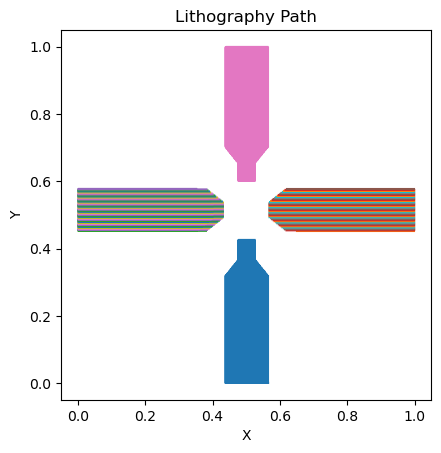

In [329]:
plot_lithography_path(new_path)

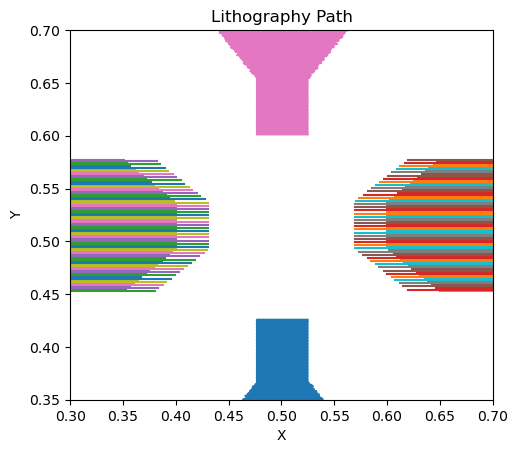

In [331]:
plot_lithography_path(new_path, x_lim = (0.3,0.7), y_lim = (0.35,0.7))

### Now print it in the format needed for MATE

In [333]:
print(f"path = {new_path};")


path = [[[0.5649431832363864, 0.00125], [0.43805681676361363, 0.00125], [0.4404431832363863, 0.00275], [0.5625568167636136, 0.00275], [0.5649431832363864, 0.00425], [0.43805681676361363, 0.00425], [0.4404431832363863, 0.00575], [0.5625568167636136, 0.00575], [0.5649431832363864, 0.00725], [0.43805681676361363, 0.00725], [0.4404431832363863, 0.00875], [0.5625568167636136, 0.00875], [0.5649431832363864, 0.01025], [0.43805681676361363, 0.01025], [0.4404431832363863, 0.01175], [0.5625568167636136, 0.01175], [0.5649431832363864, 0.01325], [0.43805681676361363, 0.01325], [0.4404431832363863, 0.01475], [0.5625568167636136, 0.01475], [0.5649431832363864, 0.01625], [0.43805681676361363, 0.01625], [0.4404431832363863, 0.01775], [0.5625568167636136, 0.01775], [0.5649431832363864, 0.01925], [0.43805681676361363, 0.01925], [0.4404431832363863, 0.02075], [0.5625568167636136, 0.02075], [0.5649431832363864, 0.02225], [0.43805681676361363, 0.02225], [0.4404431832363863, 0.02375], [0.5625568167636136, 0